# **AvStats - Flight Delay Forecast**

*Iraia Torres, October 2024*

### **Notebook 1 - Data Cleaning & EDA**

1. Data Cleaning & Processing
    * Duplicates & Missing Values
    * New Features
    * Weather dataframe (meteostat)
    * Passenger dataframe (eurostats)
    * Merge dataframes (Flight schedule, Weather and Total Passengers)
2. Exploratory Data Analysis
    * Flight Status
    * Flight Performance
    * Time Window
    * Flight Category Comparison
    * Airline Delays
    * Frequent Routes and Airports


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from core.DataLoader import DataLoader
from core.EDA_workflow.DataProcessing import DataProcessing
from core.EDA_workflow.FlightPerformance import FlightPerformance
from core.EDA_workflow.WeatherData import WeatherData
from core.EDA_workflow.MergeData import MergeData
from core.EDA_workflow.PassengerData import PassengerData
from avstats.core.EDA_utils import *
from avstats.core.general_utils import *

In [2]:
data_loader = DataLoader(config_path='config.yaml')
df_avstats, df_passengers, airport_mapping = data_loader.load_data()

if df_avstats is None or df_passengers is None or airport_mapping is None:
    raise SystemExit("Data files are missing or failed to load. Please check your configuration.")

### **1. Data Cleaning & Processing**
    
##### **Duplicates & Missing Values**

These are the changes made to fill out all the missing values in the dataset.
* Delay minutes NaN -> 0
* Actual departure time (adt) NaN -> Calculate it based on scheduled departure time (sdt) and delay minutes
* Actual arrival time (aat) NaN -> Calculate it based on scheduled arrival time (sat) and delay minutes
* When private flight -> Airline code and flight number as NONE
* Calculate the NaN values for both the calculated scheduled and actual flight time
    
##### **New Features**

1. Binary column for delays (dep_delay_15): delayed over 15min. (1) or not delayed (0)      
2. Categorize delays (dep_delay_cat): short under 15 min., medium 15 - 60 min. or long over 60 min.
3. Flight category (flight_cat): cargo, commercial, or private.
4. Set dep & arr times into time windows (dep_time_window & arr_time_window):
    * Morning (00:00 to 11:59)
    * Afternoon (12:00 to 17:59)
    * Night (18:00 to 23:59)

In [3]:
data_processing = DataProcessing(df_avstats, unique_column='uuid')
df = data_processing.preprocess_avstats()
negative_dep_delay_rows = df[df['dep_delay'] < 0] # Filter rows where 'dep_delay' is negative (on time flights)
df.head(10)

,uuid,route_iata_code,type,status,dep_iata_code,dep_delay,sdt,adt,arr_iata_code,sat,...,flight_iata_number,calc_sft,calc_aft,calc_flight_distance_km,dep_delay_15,dep_delay_cat,flight_cat,dep_time_window,arr_time_window,on_time_15
0,D4B953A52B6B376A144AFA95DBCF5C14D7154C83,BRU-CPH,ARRIVAL,LANDED,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,...,SK1594,90.0,65.0,754.4,0,Short,Commercial,Afternoon,Afternoon,1
1,476BC61CB63C6766B18F9AF8AF60D3A8F66FF08C,OUD-BRU,ARRIVAL,LANDED,OUD,10.0,2023-08-15 14:00:00+00:00,2023-08-15 14:10:00+00:00,BRU,2023-08-15 16:55:00+00:00,...,AT1688,175.0,153.0,1864.7,0,Short,Commercial,Afternoon,Afternoon,1
2,412CDB45D7CC4CF4C637C50D443E4649773C1787,BRU-CPH,DEPARTURE,ACTIVE,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,...,SK1594,90.0,90.0,754.4,0,Short,Commercial,Afternoon,Afternoon,1
3,01549CD997A261C77CD8CDE664172687D13255BF,IBZ-BRU,ARRIVAL,LANDED,IBZ,23.0,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,BRU,2023-08-15 16:20:00+00:00,...,SN3778,135.0,115.0,1359.5,1,Medium,Commercial,Afternoon,Afternoon,0
4,8CBE8A849C7510077FA66B228920701423E8C976,OTP-BRU,ARRIVAL,SCHEDULED,OTP,90.0,2023-08-15 14:05:00+00:00,2023-08-15 15:34:00+00:00,BRU,2023-08-15 16:55:00+00:00,...,RO373,170.0,171.0,1754.8,1,Long,Commercial,Afternoon,Evening,0
5,C71A1480E0780A51C0B9174E0E8A5695BDD0CDE2,IBZ-BRU,DEPARTURE,ACTIVE,IBZ,23.0,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,BRU,2023-08-15 16:20:00+00:00,...,SN3778,135.0,136.0,1359.5,1,Medium,Commercial,Afternoon,Afternoon,0
7,425B80B4EF9940D2F59108D839749E6B52696ED5,MLA-BRU,ARRIVAL,LANDED,MLA,30.0,2023-08-15 14:10:00+00:00,2023-08-15 14:40:00+00:00,BRU,2023-08-15 17:05:00+00:00,...,KM420,175.0,153.0,1853.6,1,Medium,Commercial,Afternoon,Afternoon,0
8,884CA852266F99E514393771BA858A2F8851D5D6,BRU-ALC,DEPARTURE,ACTIVE,BRU,35.0,2023-08-15 14:10:00+00:00,2023-08-15 14:44:00+00:00,ALC,2023-08-15 16:40:00+00:00,...,HV9005,150.0,151.0,1458.0,1,Medium,Commercial,Afternoon,Afternoon,0
9,BD3202B4E6C1CD1DFC6ACB722D1C6500C08951F6,BRU-ALC,ARRIVAL,LANDED,BRU,35.0,2023-08-15 14:10:00+00:00,2023-08-15 14:44:00+00:00,ALC,2023-08-15 16:40:00+00:00,...,HV9005,150.0,125.0,1458.0,1,Medium,Commercial,Afternoon,Afternoon,0
10,65097B9852945F3990B0991781555483AE2EB102,MLA-BRU,DEPARTURE,ACTIVE,MLA,20.0,2023-08-15 14:10:00+00:00,2023-08-15 14:30:00+00:00,BRU,2023-08-15 17:05:00+00:00,...,KM420,175.0,175.0,1853.6,1,Medium,Commercial,Afternoon,Afternoon,0


Missing Values: 0
Duplicate Rows: None
Missing by Column: Series([], dtype: int64)


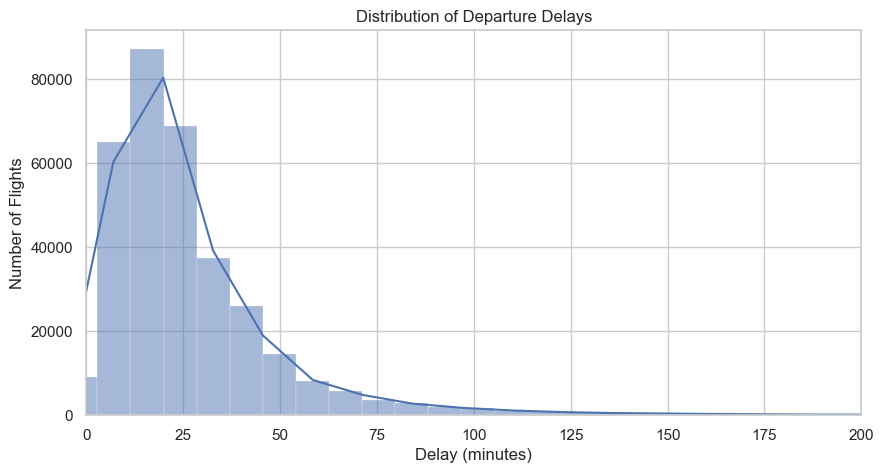

In [4]:
# Analyze Data Quality
quality_metrics = data_processing.check_missing_and_duplicates(df)
print("Missing Values:", quality_metrics['missing_values'])
print("Duplicate Rows:", quality_metrics['duplicate_rows'])
print("Missing by Column:", quality_metrics['missing_by_column'])

# Delay Distribution
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(df['dep_delay'], bins=300, kde=True)
plt.title("Distribution of Departure Delays")
plt.xlabel("Delay (minutes)")
plt.ylabel("Number of Flights")
plt.xlim(0, 200) 
plt.show()

In [5]:
# Performance Summary
flight_performance = FlightPerformance(df)
performance_metrics = flight_performance.overall_performance()
print("Overall Flight Performance Percentage:")
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.2f}%")

# Delay Ranges
delay_ranges = [(0, 60), (60, 120), (120, 180), (180, float('inf'))]
delay_summary = flight_performance.delay_ranges_summary(delay_ranges)
print("\nDelay Summary:")
for range_label, percentage in delay_summary.items():
    print(f"Delays {range_label}: {percentage:.2f}%")

Overall Flight Performance Percentage:
Delayed Flights (%): 64.05%
On-Time Flights (%): 32.31%
Missing Status (%): 3.64%

Delay Summary:
Delays 0-60 minutes: 91.00%
Delays 60-120 minutes: 5.67%
Delays 120-180 minutes: 0.82%
Delays 180-inf minutes: 0.44%


#### **1.2. Weather dataframe (meteostat)**
* Create new latitude and longitude (coordinate) columns for both departure and arrival airports
* Fetch weather data based on the route and date
* Handle missing values by dropping flights with missing temperatures and filling the rest with 0

In [12]:
warnings.filterwarnings("ignore", category=UserWarning)
weather_fetcher = WeatherData(df)
weather_fetcher.assign_coordinates().head()
weather_fetcher.fetch_weather_data()
df_weather_merged = weather_fetcher.merge_weather_with_flights()

Assigning coordinates...
Starting weather data fetch for 807 coordinate pairs from 2023-01-01 00:00:00 to 2024-01-01 00:00:00.
Fetched weather for 900 / 807 coordinates.
Fetched weather for 1200 / 807 coordinates.
Fetched weather for 200 / 807 coordinates.
Fetched weather for 600 / 807 coordinates.
Fetched weather for 182600 / 807 coordinates.
Fetched weather for 204400 / 807 coordinates.
Weather data fetching completed with 285304 records.
adt and aat were successfully turned into datetime format.
Weather data was merged with schedule data successfully.


In [13]:
# Remove duplicates from the duplicate_rows DataFrame
df_weather_merged = df_weather_merged.drop_duplicates()

# Drop rows where 'tavg_dep' has missing values
df_weather_merged = df_weather_merged.dropna(subset=['tavg_dep', 'tavg_arr'])

# Convert categorical columns to strings
df_weather_merged = df_weather_merged.apply(lambda col: col.astype(str) if col.dtype.name == 'category' else col)

# Fill all missing values with 0
df_weather_merged.fillna(0, inplace=True)
df_weather_merged.head()

,uuid,route_iata_code,type,status,dep_iata_code,dep_delay,sdt,adt,arr_iata_code,sat,...,tmax_arr,prcp_arr,snow_arr,wdir_arr,wspd_arr,wpgt_arr,pres_arr,tsun_arr,arr_lat_y,arr_lon_y
0,D4B953A52B6B376A144AFA95DBCF5C14D7154C83,BRU-CPH,ARRIVAL,LANDED,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,...,22.7,0.0,0.0,160.0,12.8,31.5,1014.8,0.0,55.6179,12.65600
4,476BC61CB63C6766B18F9AF8AF60D3A8F66FF08C,OUD-BRU,ARRIVAL,LANDED,OUD,10.0,2023-08-15 14:00:00+00:00,2023-08-15 14:10:00+00:00,BRU,2023-08-15 16:55:00+00:00,...,25.6,1.0,0.0,252.0,10.5,27.8,1016.0,0.0,50.9014,4.48444
8,412CDB45D7CC4CF4C637C50D443E4649773C1787,BRU-CPH,DEPARTURE,ACTIVE,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,...,22.7,0.0,0.0,160.0,12.8,31.5,1014.8,0.0,55.6179,12.65600
12,01549CD997A261C77CD8CDE664172687D13255BF,IBZ-BRU,ARRIVAL,LANDED,IBZ,23.0,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,BRU,2023-08-15 16:20:00+00:00,...,25.6,1.0,0.0,252.0,10.5,27.8,1016.0,0.0,50.9014,4.48444
16,8CBE8A849C7510077FA66B228920701423E8C976,OTP-BRU,ARRIVAL,SCHEDULED,OTP,90.0,2023-08-15 14:05:00+00:00,2023-08-15 15:34:00+00:00,BRU,2023-08-15 16:55:00+00:00,...,25.6,1.0,0.0,252.0,10.5,27.8,1016.0,0.0,50.9014,4.48444


In [14]:
# Initialize the aggregator
aggregator = MergeData(df_weather_merged)

# Preprocess the datetime column (assume 'sdt' is the column name)
aggregator.preprocess_datetime()

# Aggregate daily
df_grouped_daily = aggregator.aggregate_daily(passenger_data=False)
df_grouped_daily

,route_iata_code,Date,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay,total_dep_delay_15,...,avg_pres_dep,total_tsun_dep,avg_tavg_arr,total_prcp_arr,avg_snow_arr,avg_wdir_arr,avg_wspd_arr,avg_wpgt_arr,avg_pres_arr,total_tsun_arr
0,AAL-BRU,2023-09-09,5,3,2,1,3,1,576.0,4,...,1016.4,0.0,23.3,0.0,0.0,94.0,4.5,18.5,1017.0,0.0
1,ABJ-BRU,2023-01-01,2,1,1,1,1,0,80.0,2,...,1011.0,0.0,10.1,14.4,0.0,233.0,19.4,44.5,1017.1,0.0
2,ABJ-BRU,2023-01-04,2,1,1,1,1,0,72.0,2,...,1011.4,0.0,11.0,2.2,0.0,244.0,20.4,46.3,1021.0,0.0
3,ABJ-BRU,2023-01-06,2,1,1,1,1,0,88.0,2,...,1012.0,0.0,10.3,0.2,0.0,194.0,24.3,46.3,1010.4,0.0
4,ABJ-BRU,2023-01-08,2,1,1,1,1,0,48.0,2,...,1011.7,0.0,6.7,1.0,0.0,237.0,23.0,46.3,1000.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74933,ZTH-BRU,2023-10-14,2,1,1,1,1,0,18.0,0,...,1016.9,0.0,12.1,8.4,0.0,259.0,20.7,48.2,1013.2,0.0
74934,ZTH-BRU,2023-10-15,2,1,1,1,1,0,34.0,2,...,1013.1,0.0,8.3,2.2,0.0,258.0,13.1,29.6,1022.7,0.0
74935,ZTH-BRU,2023-10-21,2,1,1,1,1,0,32.0,2,...,1015.0,0.0,13.4,1.8,0.0,190.0,24.0,51.8,990.2,0.0
74936,ZTH-BRU,2023-10-22,2,1,1,1,1,0,24.0,0,...,1015.8,0.0,12.6,5.8,0.0,219.0,15.0,51.8,1005.6,0.0


In [15]:
save_dataframe(df_grouped_daily, "df_weather")

DataFrame saved to ..\data\df_weather.csv


#### **1.4. Passenger dataframe (External data)**

In [16]:
passengers = PassengerData(df_passengers, airport_mapping)
df_passengers_cleaned = passengers.process_passenger_data()
aggregator.aggregate_daily(passenger_data=True)
df_merged = aggregator.aggregate_passengers(df_passengers_cleaned)
df_merged.head()

,route_iata_code,Month,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay,total_dep_delay_15,...,avg_tavg_arr,total_prcp_arr,avg_snow_arr,avg_wdir_arr,avg_wspd_arr,avg_wpgt_arr,avg_pres_arr,total_tsun_arr,route_code,total_passengers
0,BRU-ACC,2023-01,42,21,21,18,21,3,1529.0,36,...,28.604762,9.5,0.0,219.404762,12.921429,0.0,1010.616667,0.0,BRU-ACC,10006
1,BRU-ACC,2023-02,35,19,16,14,19,2,1206.0,25,...,29.265714,10.5,0.0,199.257143,13.960000,0.0,1009.900000,0.0,BRU-ACC,8645
2,BRU-ACC,2023-03,46,22,24,17,22,7,1544.0,37,...,28.656522,55.6,0.0,220.304348,13.467391,0.0,1010.054348,0.0,BRU-ACC,10371
3,BRU-ACC,2023-04,37,18,19,15,18,4,1380.0,32,...,29.067568,62.9,0.0,224.189189,14.245946,0.0,1009.391892,0.0,BRU-ACC,11042
4,BRU-ACC,2023-05,39,18,21,17,18,2,1624.0,37,...,28.769231,165.4,0.0,220.615385,11.605128,0.0,1011.353846,0.0,BRU-ACC,10879


In [17]:
save_dataframe(df_merged, "df_merged")

DataFrame saved to ..\data\df_merged.csv


### **2. Exploratory Data Analysis (EDA)**
* Flight Status
* Flight Performance
* Time Window
* Flight Category Comparison
* Airline Delays
* Frequent Routes and Airports

#### **2.1. Flight Status**
The **proportion** of different **flight statuses** (active, canceled, scheduled, diverted) using a pie chart.

In [21]:
status_summary = get_status_summary(df) # Get the status summary DataFrame
status_summary

,Status,Total Flights,Proportions (%)
0,ACTIVE,170979,50.24
1,LANDED,154201,45.31
2,SCHEDULED,14869,4.37
3,DIVERTED,249,0.07


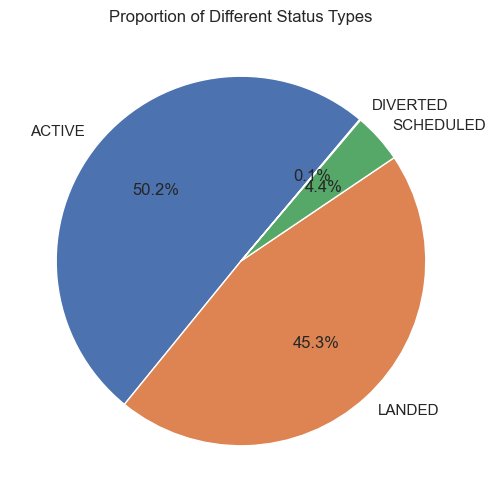

In [22]:
status_summary = get_status_summary(df)
status_proportions = status_summary['Proportions (%)']  # Extract status proportions for plotting

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.pie(status_proportions, labels=status_summary['Status'], autopct='%1.1f%%', startangle=50)
plt.title('Proportion of Different Status Types')
plt.show()

#### **2.2. Flight Performance**

Visualize the **distribution** of **delayed flights** across the dataset.
- Histogram for delayed minutes
- Histogram for delayed/not delayed flights

In [23]:
flight_performance = FlightPerformance(df)
percentages = flight_performance.overall_performance() # Calculate overall performance
print("Overall Flight Performance Percentage\n")
for label, percent in percentages.items():
    print(f"{label}: {percent:.2f}%")

# Define delay ranges and labels
delay_ranges = [
    (0, 60, "0 - 60 minutes"),
    (60, 120, "60 - 120 minutes"),
    (120, 180, "120 - 180 minutes"),
    (180, None, "over 180 minutes")
]

delay_percentages = flight_performance.delayed_flight_percentages(delay_ranges) # Calculate and print delay percentages for each range
print("\nPercentage of Delayed Flights\n")
for label, percent in delay_percentages.items():
    print(f"Between {label}: {percent:.2f}%")

Overall Flight Performance Percentage

Delayed Flights: 64.05%
On-Time Flights: 32.31%
Flights with Missing Status: 3.64%

Percentage of Delayed Flights

Between 0 - 60 minutes: 64.05%
Between 60 - 120 minutes: 0.00%
Between 120 - 180 minutes: 0.00%
Between over 180 minutes: 0.00%


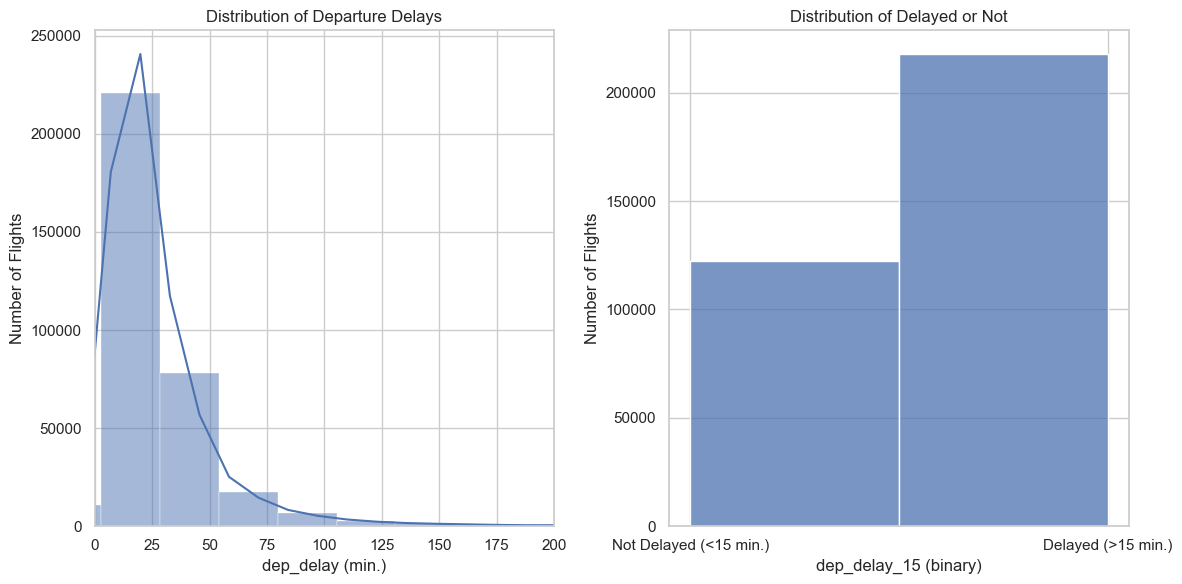

In [28]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # Distribution of dep_delay
sns.histplot(df['dep_delay'], bins=100, kde=True)  # kde=True adds a smooth curve
plt.title('Distribution of Departure Delays')
plt.xlabel('dep_delay (min.)')
plt.ylabel('Number of Flights')
plt.xlim(0, 200) 

plt.subplot(1, 2, 2) # Distribution of dep_delay_15 
sns.histplot(df['dep_delay_15'], bins=2, kde=False)  # Binary values (0 and 1)
plt.title('Distribution of Delayed or Not')
plt.xlabel('dep_delay_15 (binary)')
plt.ylabel('Number of Flights')
plt.xticks(ticks=[0, 1], labels=['Not Delayed (<15 min.)', 'Delayed (>15 min.)'])

plt.tight_layout()
plt.show()

#### **2.3. Time window**
Understand how flight schedules (departure time sdt and arrival time sat) influence **delays** across different **time windows** (morning, afternoon, night)

In [21]:
dep_flight_summary = flight_summary_by_time_window(df, 'dep_time_window', summarize_delays=True)
arr_flight_summary = flight_summary_by_time_window(df, 'arr_time_window', summarize_delays=True)
time_window_proportions = calculate_time_window_percentages(df)
time_window_proportions

,Departure Percentages (%),Arrival Percentages (%)
Time Window,,
Morning,50.28,40.17
Afternoon,31.21,32.70
Evening,18.51,27.13


In [22]:
dep_flight_summary

,dep_time_window,total_flights,delayed_flights,dep_time_window_proportion_delayed,dep_time_window_percentage_delayed
0,Afternoon,106208,69602,0.655337,65.53%
1,Evening,62975,40192,0.638222,63.82%
2,Morning,171115,108152,0.632043,63.2%


In [23]:
arr_flight_summary

,arr_time_window,total_flights,delayed_flights,arr_time_window_proportion_delayed,arr_time_window_percentage_delayed
0,Afternoon,111278,75096,0.674850,67.49%
1,Evening,92317,59590,0.645493,64.55%
2,Morning,136703,83260,0.609058,60.91%


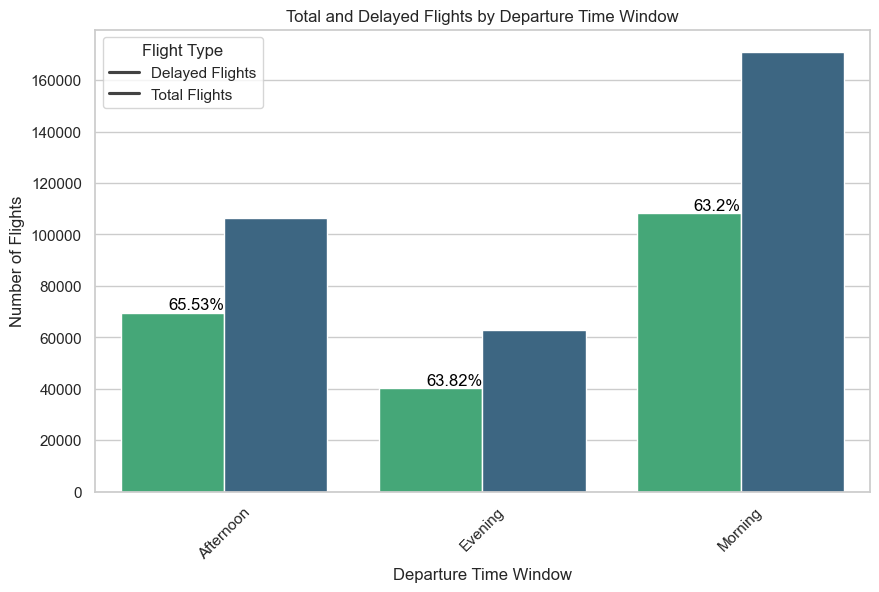

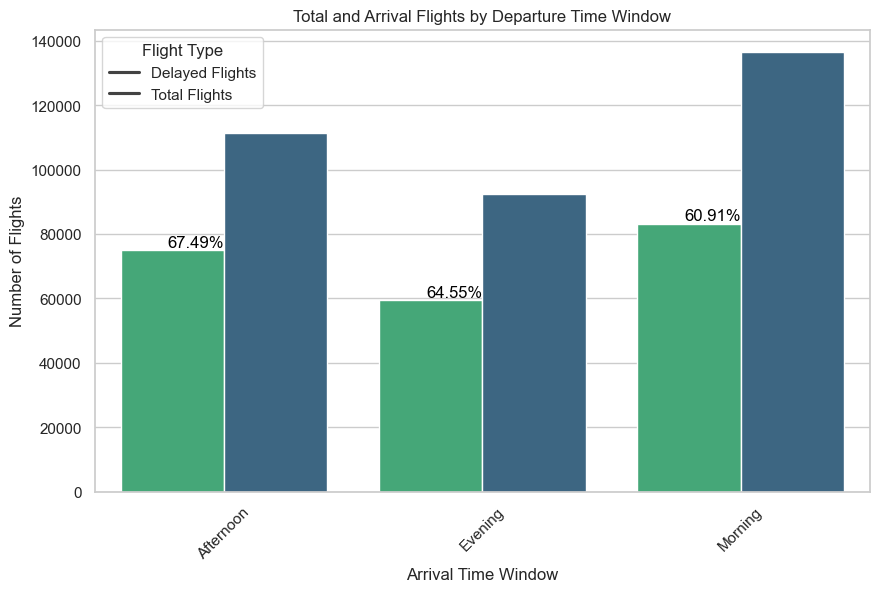

In [24]:
# New df for the bar plots
dep_bar_data = pd.melt(dep_flight_summary, id_vars='dep_time_window', value_vars=['delayed_flights', 'total_flights'],var_name='flight_type', value_name='count')
arr_bar_data = pd.melt(arr_flight_summary, id_vars='arr_time_window', value_vars=['delayed_flights', 'total_flights'],var_name='flight_type', value_name='count')

# Shift left for delayed flights and right for total flights
dep_bar_data['position'] = dep_bar_data['flight_type'].map({'delayed_flights': -0.2, 'total_flights': 0.2})
arr_bar_data['position'] = arr_bar_data['flight_type'].map({'delayed_flights': -0.2, 'total_flights': 0.2})

# Plot for Total and Delayed Arrival Flights
plt.figure(figsize=(10, 6))
ax=sns.barplot(data=dep_bar_data, x='dep_time_window', y='count', hue='flight_type', dodge=True, palette=['#35b779', '#31688e'])
for index, row in dep_flight_summary.iterrows():
    if row['delayed_flights'] > 0:  # Only display if there are delayed flights
        ax.text(index, row['delayed_flights'], f"{row['dep_time_window_percentage_delayed']}", color='black', ha='right', va='bottom', fontsize=12)
plt.title('Total and Delayed Flights by Departure Time Window')
plt.ylabel('Number of Flights')
plt.xlabel('Departure Time Window')
plt.xticks(rotation=45)
plt.legend(title='Flight Type', labels=['Delayed Flights', 'Total Flights'])
plt.show()

# Plot for Total and Delayed Departure Flights
plt.figure(figsize=(10, 6))
bx=sns.barplot(data=arr_bar_data, x='arr_time_window', y='count', hue='flight_type', dodge=True, palette=['#35b779', '#31688e'])
for index, row in arr_flight_summary.iterrows():
    if row['delayed_flights'] > 0:  # Only display if there are delayed flights
        bx.text(index, row['delayed_flights'], f"{row['arr_time_window_percentage_delayed']}", color='black', ha='right', va='bottom', fontsize=12)
plt.title('Total and Arrival Flights by Departure Time Window')
plt.ylabel('Number of Flights')
plt.xlabel('Arrival Time Window')
plt.xticks(rotation=45)
plt.legend(title='Flight Type', labels=['Delayed Flights', 'Total Flights'])
plt.show()

#### **2.4. Flight Category Comparison**
Comparison of the **on-time performance** of cargo, private, & commercial flights and the **distribution** of delay times within them.

In [25]:
on_time_performance = calculate_on_time_performance(df)
flight_percentages = calculate_flight_percentages(df)

# Combine both DataFrames
combined_performance = pd.merge(on_time_performance, flight_percentages, on='Flight Category', how='left')
combined_performance

,Flight Category,Total Flights,On-Time Performance,Flight Amount Percentage
0,Cargo,20062,30.53%,5.9%
1,Commercial,315485,32.36%,92.71%
2,Private,4751,36.77%,1.4%


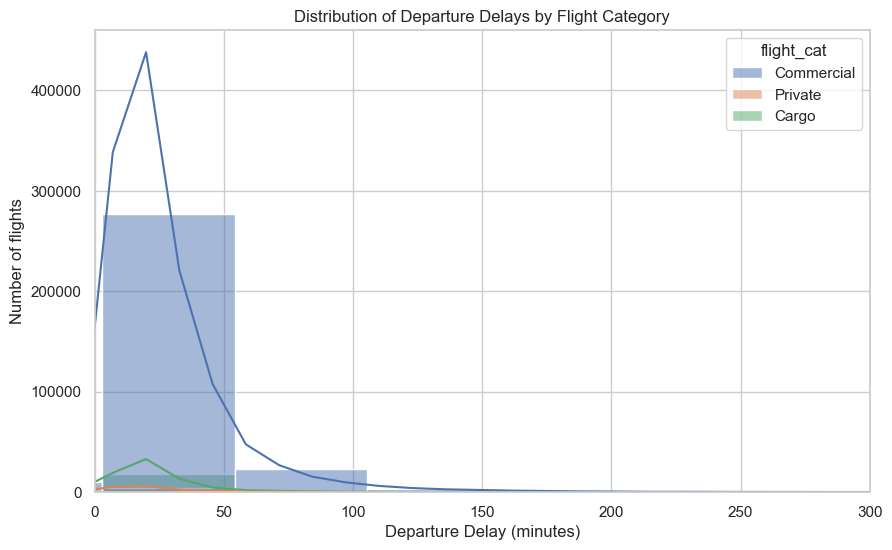

In [26]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='dep_delay', hue='flight_cat', kde=True, bins=50)
plt.xlim(0, 300)  # 300 minutes for better visualization
plt.title('Distribution of Departure Delays by Flight Category')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Number of flights')
plt.show()

#### **2.5. Airline Delays**
The total volume of flights and the percentage of delayed flights by airlines.

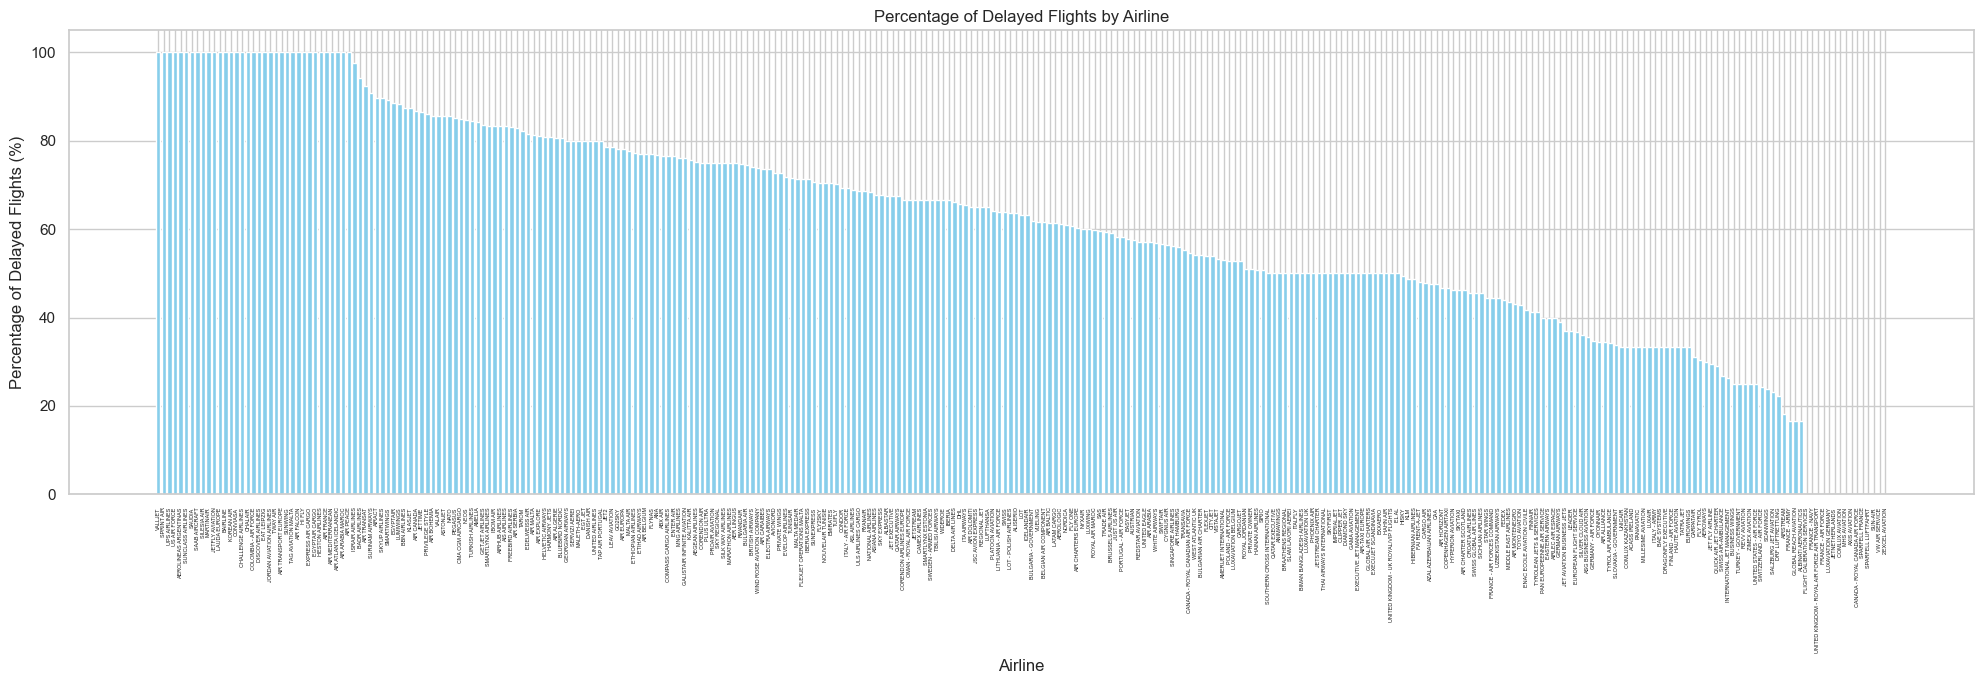

In [27]:
# Total volume of flights by airline
total_flights_airline = df.groupby('airline_name')['uuid'].count().reset_index()
total_flights_airline.columns = ['airline_name', 'total_flights']

# Delayed flights by airline
delayed_flights_airline = df[df['dep_delay_15'] == 1].groupby('airline_name')['uuid'].count().reset_index()
delayed_flights_airline.columns = ['airline_name', 'delayed_flights']

# Percentage of delayed flights
flights_summary = pd.merge(total_flights_airline, delayed_flights_airline, on='airline_name', how='left')
flights_summary['delayed_flights'] = flights_summary['delayed_flights'].fillna(0).astype(int)  # Handling NaNs
flights_summary['percent_delayed(%)'] = ((flights_summary['delayed_flights'] / flights_summary['total_flights']) * 100).round(2)

sorted_flights_summary = flights_summary.sort_values(by='percent_delayed(%)', ascending=False)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(20,7))
plt.bar(sorted_flights_summary['airline_name'], sorted_flights_summary['percent_delayed(%)'], color='skyblue')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('Airline')
plt.ylabel('Percentage of Delayed Flights (%)')
plt.title('Percentage of Delayed Flights by Airline')
plt.tight_layout()
plt.show()

#### **2.6. Frequent Routes and Airports**
Routes and airports in Brussels with the highest percentage of delays.

                  airline_name route_iata_code  average_dep_delay
1118           EVELOP AIRLINES         BRU-VRA             564.00
1703       LUXAVIATION BELGIUM         BOO-BRU             526.00
62            AIR ARABIA MAROC         BRU-FEZ             416.00
1077        ETHIOPIAN AIRLINES         BRU-JNB             342.55
894   CORENDON AIRLINES EUROPE         HRG-BRU             340.00


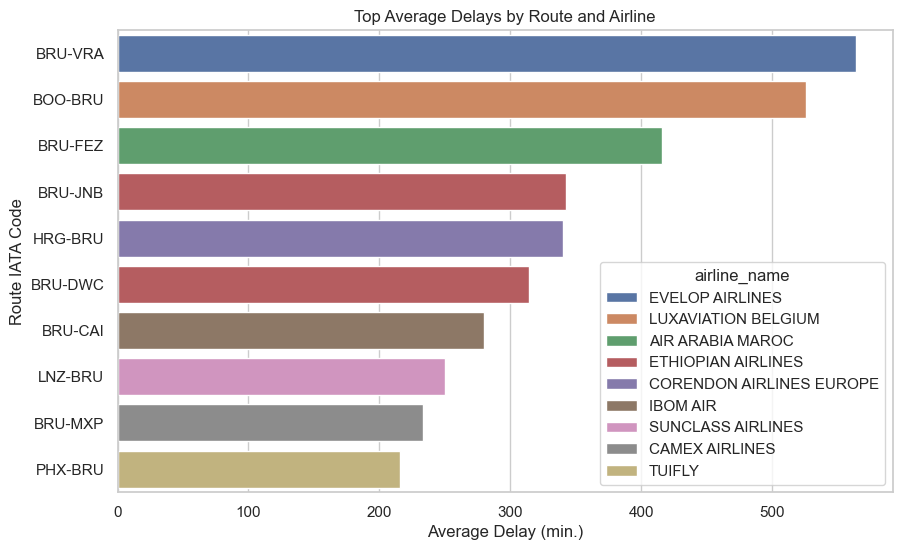

In [28]:
# Calculate and print average delays
average_delay_sorted = calculate_average_delay(df)
print(average_delay_sorted.head())

top_delays = average_delay_sorted.head(10) # Plot the top 10 average delays
plt.figure(figsize=(10, 6))
sns.barplot(x='average_dep_delay', y='route_iata_code', hue='airline_name', data=top_delays, dodge=False)
plt.title('Top Average Delays by Route and Airline')
plt.xlabel('Average Delay (min.)')
plt.ylabel('Route IATA Code')
plt.show()

#### **2.8. EDA Conclusions**

1. Most of the flights in the dataset are delayed. **Delayed Flights: 61.97%**
2. Most of the delays happen within the first hour. **Between 0 - 60 minutes: 88.05%**
3. Top 10 airline & route delays
4. Most flights are scheduled to depart in the morning. **Departure (Morning): 50.35%**
5. Most flights are scheduled to arrive in the morning. **Arrival (Morning): 40.07%**
6. The delay within departure flights throughout the day is similar
    * **Afternoon: 63.31%** (of the flights are delayed)
    * Evening: 62.15% 
    * Morning: 61.07% 
7. The delay within arrival flights throughout the day is similar
    * **Afternoon: 65.06%** (of the flights are delayed)
    * Evening: 62.5%
    * Morning: 58.08%
8. Most of the flights are commercial. **Commercial Flights: 92.81%**
9. The delay within departure flight throughout the day is similar
    * Cargo: 31.7%  (of the flights are delayed)
    * Commercial: 34.62%
    * **Private: 38.47%**
10. Most of the flights in the dataset are active. **Active flights: 51.04%**